## Figure 2: NaRRS Snow Depth and Sea Ice Thickness Visualized

Here we will visualize the NaRRS snow depth and sea ice thickness retrievals. This will include a day of along-track retrievals, a zoomed-in segment of the along-track data plotted over some coincident imagery of the surface, monthly-averaged pan-Arctic distributions, and monthly-averaged time series.

**Data required**
* S3 NaRRS products covering the example date (2022-04-14). A precompiled dataset including all data for this day has been saved to NaRRS/Data/NaRRS_Sentinel3_snow_depth_and_sea_ice_thickness_along_track_nh_20220414.nc.
* S3 NaRRS product for the zoomed-in segment. Availiable at NaRRS/Data/S3A_SR_2_LAN_SI_20220414T211653_20220414T213310_20230729T105126_0976_084_143______LN3_R_NT_005.SEN3. The coincident OLCI data at NaRRS/Data/S3A_OL_1_EFR____20220414T212458_20220414T212758_20240605T031041_0179_084_143_1620_MAR_R_NT_004.SEN3 / available to download from https://dataspace.copernicus.eu/.
* Monthly gridded NaRRS products on the EASE2 25 km grid for the 2021-2022 Oct-April season. Stored in NaRRS/Data/Monthly_gridded_narrs.
* Snow depth and sea ice thickness statistics computed from the monthly gridded product, including a breakdown by ice type and NSIDC-defined region. The csv file with this data is found at NaRRS/Data/S3_NaRRS_snow_depth_sit_monthly_stats_nh_2021-2022_by_region_and_type.csv.

**Software required**

In addition to the satpy Python package (https://satpy.readthedocs.io/en/stable/), we use a custom 'highlight_optimised_true_color' composite defined in the directory NaRRS/Misc/satpy_customs/composites/.


1) Import required packages

In [1]:
import sys
sys.path.append('/home/cn/NaRRS')
sys.path.append('../Misc/satpy_customs/composites')
import satpy
satpy.config.set(config_path=['../Misc/satpy_customs/'])
import os
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
from geopy.distance import geodesic
from pathlib import Path
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
from shapely.ops import transform
from satpy import Scene
from satpy.writers import get_enhanced_image
from satpy.composites import SelfSharpenedRGB
from shapely.geometry import Polygon, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

2) Define functions

In [2]:
def get_sentinel3_product_dataframe_in_interval(start_datetime, end_datetime, hemisphere, lat_limit=None, enhanced_measurements=True):
    
    """
    Get a dataframe of Sentinel-3 L2 Sea Ice Thematic products within a specified time interval, hemisphere, and optional latitude limit. 
    This function assumes the 'sentinel3_sral_products_20160921_20230430.parquet' is available in the 'NaRRS/Misc/' directory.
    This parquet file should contain metadata about the Sentinel-3 L2 Sea Ice Thematic products, including, for each product:
    - 'product_path': Path to the product file.
    - 'satellite': Satellite identifier (e.g., 'S3A' or 'S3B').
    - 'name': Name of the product.
    - 'sensing_start': Start datetime of sensing.
    - 'sensing_end': End datetime of sensing.
    - 'cycle': Orbit cycle number.
    - 'enhanced_exists': Boolean indicating if enhanced measurements are available. 
    - 'min_lat': Minimum latitude covered by the product.
    - 'max_lat': Maximum latitude covered by the product.

    Parameters:
    start_datetime (Timestamp): Start of the time interval.
    end_datetime (Timestamp): End of the time interval.
    hemisphere (str): 'nh' for Northern Hemisphere or 'sh' for Southern Hemisphere.
    lat_limit (float, optional): Latitude limit for filtering products. Defaults to None.
    enhanced_measurements (bool, optional): If True, only include products with enhanced measurements available (rarely, there is no enhanced_measurement.nc processed by ESA). Defaults to True.
    
    Returns:
    DataFrame: Filtered dataframe of Sentinel-3 products.
    
    """
    
    all_files_df = pd.read_parquet('../Data/sentinel3_sral_products_20160921_20230430.parquet')
    if enhanced_measurements:
        all_files_df = all_files_df[all_files_df['enhanced_exists'] == True]
    
    if lat_limit is not None:
        if hemisphere == 'nh':
            all_files_df = all_files_df[all_files_df['max_lat'] >= lat_limit]
        elif hemisphere == 'sh':
            all_files_df = all_files_df[all_files_df['min_lat'] <= lat_limit]
        else:
            raise ValueError('Hemisphere must be either "nh" or "sh"')

    all_files_df = all_files_df[(all_files_df['sensing_end'] >= start_datetime) & (all_files_df['sensing_start'] < end_datetime)]
    return all_files_df

#========================================================================================================================#

def transform_coords(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2
    
    Parameters:
    proj1 (int): EPSG code of the current projection
    proj2 (int): EPSG code of the target projection
    x (float or array-like): x-coordinate(s) in the current projection
    y (float or array-like): y-coordinate(s) in the current projection
    
    Returns:
    tuple: Transformed x and y coordinates in the target projection
    
    Common projections: 
    WGS 84 (4326)
    EASE2 (NH: 6931, SH:6932)
    Polar Stereographic (NH: 3413, SH:3976)
    EASE (NH:3408, SH:3409)
    """

    proj = pyproj.Transformer.from_crs(proj1, proj2, always_xy=True)

    return proj.transform(x, y)

#========================================================================================================================#

def get_image(scene, datasetID):
    """Generate self-sharpened RGB composite from Satpy Scene object.
    This should help bring out finer features in the image.
    
    Parameters:
    scene (satpy.Scene): Satpy Scene object containing satellite data.
    datasetID (str): Identifier for the dataset within the Scene to be processed.
    Returns:
    xarray.DataArray: Enhanced RGB composite image.
    """
    
    compositor = SelfSharpenedRGB('self_sharpened_composite')
    composite = compositor(scene[datasetID])
    composite.attrs = scene[datasetID].attrs
    return get_enhanced_image(composite)

#========================================================================================================================#

def get_olci_polygon(xcs, ycs):
    """
    Generate a Shapely Polygon representing the boundary of OLCI data coverage.
    
    Parameters:
    xcs (2D array-like): Array of x-coordinates of OLCI data points.
    ycs (2D array-like): Array of y-coordinates of OLCI data points.
    
    Returns:
    shapely.geometry.Polygon: Polygon representing the OLCI data coverage boundary.
    """
    
    x_boundary = np.concatenate([xcs[0,:], xcs[:,-1], np.flip(xcs[-1, :]), np.flip(xcs[:,0])])
    y_boundary = np.concatenate([ycs[0,:], ycs[:,-1], np.flip(ycs[-1, :]), np.flip(ycs[:,0])])
    return Polygon(zip(x_boundary, y_boundary))

#=============================================================================================================================================================#

def is_point_in_olci_polygon(point, olci_polygon):
    """
    Check if a given point is inside the OLCI polygon.
    
    Parameters:
    point (shapely.geometry.Point): The point to check.
    olci_polygon (shapely.geometry.Polygon): A shapely polygon representing OLCI data coverage.
    
    Returns:
    bool: True if the point is inside the polygon, False otherwise.
    """
    
    return olci_polygon.contains(point)

#=============================================================================================================================================================#

def crop_ds_to_olci(ds, olci_polygon, time_dim='time_01'):
    """
    Crop an xarray Dataset to only include data points within the OLCI polygon.
    
    Parameters:
    ds (xarray.Dataset): The dataset to be cropped.
    olci_polygon (shapely.geometry.Polygon): A shapely polygon representing OLCI data coverage.
    time_dim (str): The name of the time dimension in the dataset. It is assumed that the x and y coordinates are named 'xc_<suffix>' and 'yc_<suffix>', where <suffix> is derived from the time dimension name, e.g., 'time_01' -> '01'.
    
    Returns:
    xarray.Dataset: The cropped dataset containing only points within the OLCI polygon.
    """
    
    mwr_data_points = [Point(x, y) for x, y in zip(ds[f'xc_{time_dim.split("time_")[1]}'], ds[f'yc_{time_dim.split("time_")[1]}'])]
    in_olci = Parallel(n_jobs=32, prefer="threads")(delayed(is_point_in_olci_polygon)(point, olci_polygon) for point in mwr_data_points)
    cropped_ds = ds.where(xr.DataArray(in_olci, dims=time_dim), drop=True)
    return cropped_ds

#=============================================================================================================================================================#

def get_circular_geospatial_polygon(xc, yc, r, coord_epsg, return_epsg=None):
    """
    Generate a circular polygon around a given center point.
    
    Parameters:
    xc (float): x-coordinate of the center point.
    yc (float): y-coordinate of the center point.
    r (float): radius of the circular footprint.
    coord_epsg (int): EPSG code of the input coordinates.
    return_epsg (int, optional): EPSG code to transform the polygon to. If None, the polygon is returned in the original coordinate system.
    
    Returns:
    shapely.geometry.Polygon: Circular polygon.
    """
    
    theta = np.linspace(0,2*np.pi, 100)
    theta = np.append(theta,0)
    x_bounds = xc+ r*np.cos(theta)
    y_bounds = yc + r*np.sin(theta)
    polygon = Polygon(list(map(list,zip(x_bounds,y_bounds))))
    
    if return_epsg is None:
        return polygon
    
    transformer = pyproj.Transformer.from_crs(pyproj.CRS(f"EPSG:{coord_epsg}"), pyproj.CRS(f"EPSG:{return_epsg}"), always_xy=True)
    return transform(transformer.transform, polygon)


#==============================================================================================================================================================#

def get_month_centre_reference_day(month):
    """
    Get the reference day for the center of a month.
    Parameters:
    month (int or str): Month as an integer (1-12) or a three-letter abbreviation (e.g., 'Jan', 'Feb', etc.).
    
    Returns:
    int: Reference day for the center of the month.
    """
    if month == 2 or month == 'Feb':
        return 14
    return 15


3) Load precompiled daily NaRRS snow depth and sea ice thickness product for the example date

In [3]:
#set the date
date = pd.to_datetime('2022-04-14')
#set hemisphere
hemisphere = 'nh'
#open the dataset
date_s3_ds = xr.open_dataset(f'../Data/NaRRS_Sentinel3_snow_depth_and_sea_ice_thickness_along_track_{hemisphere}_{date.strftime("%Y%m%d")}.nc')

#remove any data where the sea ice thickness is negative or extreme ( > 10.5 m)
date_s3_ds = date_s3_ds.where(~((date_s3_ds['negative_sit_flag_01'] == 1) | (date_s3_ds['extreme_sit_flag_01'] == 1)), drop=True)

#print some stats to help decide appropriate color scale limits
print(f"Snow depth min on {date.strftime('%Y-%m-%d')}: {date_s3_ds['snow_depth_01'].min().values} m, max: {date_s3_ds['snow_depth_01'].max().values} m")
print(f"Sea ice thickness min on {date.strftime('%Y-%m-%d')}: {date_s3_ds['sea_ice_thickness_01'].min().values} m, max: {date_s3_ds['sea_ice_thickness_01'].max().values} m")

Snow depth min on 2022-04-14: 0.005 m, max: 0.488 m
Sea ice thickness min on 2022-04-14: 0.010179434150286519 m, max: 5.215464310277834 m


4) Define the bounding box for our zoomed-in Beaufort Sea segment

In [4]:
# Constants
EPSG_CODE = 6931

#define bounding box lims
bbox = [-142.6, -133.2, 72.4, 77.62]  # [west, east, south, north]
#make a polygon of the bbox
bbox_polygon = Polygon([(bbox[0], bbox[2]), (bbox[1], bbox[2]), (bbox[1], bbox[3]), (bbox[0], bbox[3]), (bbox[0], bbox[2])])

5) Load coincident OLCI data to add context to our Beaufort Sea segement

In [5]:
#load OLCI data using satpy
olci_fpath = '../Data/S3A_OL_1_EFR____20220414T212458_20220414T212758_20240605T031041_0179_084_143_1620_MAR_R_NT_004.SEN3'
scn = Scene(reader='olci_l1b', filenames=glob(olci_fpath+'/*'))

#create a true color composite
# composite = 'true_color'
composite = 'highlight_optimised_true_color'
scn.load([composite])
lons, lats = scn[composite].attrs['area'].get_lonlats()
xcs, ycs = transform_coords(4326, EPSG_CODE, lons, lats)
img = get_image(scn, composite)
img_rgb = img.data.transpose('y','x','bands')
img_rgb = img_rgb.clip(0,1)

#add the lons and lats to the image
img_rgb['xcs'] = (('y', 'x'), xcs)
img_rgb['ycs'] = (('y', 'x'), ycs)
img_rgb['lons'] = (('y', 'x'), lons)
img_rgb['lats'] = (('y', 'x'), lats)

#crop the image to the bounding box
img_rgb = img_rgb.compute()
img_rgb = img_rgb.where((img_rgb['lons'] >= bbox[0]) & (img_rgb['lons'] <= bbox[1]) &
                        (img_rgb['lats'] >= bbox[2]) & (img_rgb['lats'] <= bbox[3]), drop=True)

#Crop the MWR dataset to the OLCI polygon
olci_polygon = get_olci_polygon(img_rgb['xcs'], img_rgb['ycs'])

/home/cn/.conda/envs/pysiralp/lib/python3.9/site-packages/xarray/namedarray/core.py:514: UserWarning: Duplicate dimension names present: dimensions {'bands'} appear more than once in dims=('bands', 'bands'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/cn/.conda/envs/pysiralp/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
Don't know how to open the following files: {'../Data/S3A_OL_1_EFR____20220414T212458_20220414T212758_20240605T031041_0179_084_1

/home/cn/.conda/envs/pysiralp/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/cn/.conda/envs/pysiralp/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/cn/.conda/envs/pysiralp/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/home/cn/.local/lib/python3.9/site-packages/satpy/composites/__init__.py:1176: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(av_data.reshape(new_shape), axis=(1, 3))


6) Load the NaRRS product corresponding to the Beaufort Sea segment and crop to the region bound by the OLCI data

In [6]:
#S3 L2 SI Thematic name
l2_product_name = 'S3A_SR_2_LAN_SI_20220414T211653_20220414T213310_20230729T105126_0976_084_143______LN3_R_NT_005.SEN3'
#load the processed S3 NaRRS snow depth and SIT product - this will have the corrected GR in it
processed_fpath = Path(f'../Data/{l2_product_name}/NaRRS_Sentinel3_snow_depth_and_sea_ice_thickness.nc')
along_track_ds = xr.open_dataset(processed_fpath)

#apply quality flags to the ds
along_track_ds =  along_track_ds.where(~((along_track_ds['negative_sit_flag_01'] == 1) | (along_track_ds['extreme_sit_flag_01'] == 1)), drop=True)
along_track_ds = along_track_ds.dropna(dim='time_01', subset=['snow_depth_01', 'sea_ice_thickness_01'])

#crop to olci polygon
along_track_ds = crop_ds_to_olci(along_track_ds, olci_polygon)

#get the approximate segement length (calculated as the distance between the first and last point in the cropped ds)
start_point = (along_track_ds['lat_01'].values[0], along_track_ds['lon_01'].values[0])
end_point = (along_track_ds['lat_01'].values[-1], along_track_ds['lon_01'].values[-1])
segment_length_km = geodesic(start_point, end_point).km
print(f"Segment length of cropped along-track data: {segment_length_km:.2f} km")

#print the statistics of the snow depth and sea ice thickness in the dataset segement
print('Cropped segment statistics')
print("Snow depth")
print(f"Min: {along_track_ds['snow_depth_01'].min().values:.2f} m, Max: {along_track_ds['snow_depth_01'].max().values:.2f} m, Mean: {along_track_ds['snow_depth_01'].mean().values:.2f} m, Std: {along_track_ds['snow_depth_01'].std().values:.2f} m, Range: {along_track_ds['snow_depth_01'].max().values - along_track_ds['snow_depth_01'].min().values:.2f} m")
print("Sea ice thickness")
print(f"Min: {along_track_ds['sea_ice_thickness_01'].min().values:.2f} m, Max: {along_track_ds['sea_ice_thickness_01'].max().values:.2f} m, Mean: {along_track_ds['sea_ice_thickness_01'].mean().values:.2f} m, Std: {along_track_ds['sea_ice_thickness_01'].std().values:.2f} m, Range: {along_track_ds['sea_ice_thickness_01'].max().values - along_track_ds['sea_ice_thickness_01'].min().values:.2f} m") 

Segment length of cropped along-track data: 628.08 km
Cropped segment statistics
Snow depth
Min: 0.13 m, Max: 0.37 m, Mean: 0.27 m, Std: 0.06 m, Range: 0.23 m
Sea ice thickness
Min: 0.20 m, Max: 3.86 m, Mean: 2.56 m, Std: 0.81 m, Range: 3.66 m


7) Make polygons for the snow depth/sea ice thickness retrievals representing the size of the bin used to average the radar freeboard, LEW, and TED data. This is also the approximate footprint size of the 23.8 GHz MWR channel.

In [7]:
#make MWR-defined polygons of 23.5 km diameter
r = 23.5e3/2
mwr_polygons = []
for xc, yc in zip(along_track_ds['xc_01'].values, along_track_ds['yc_01'].values):
    mwr_polygons.append(get_circular_geospatial_polygon(xc, yc, r, coord_epsg=EPSG_CODE, return_epsg=4326))

#set the color for each snow depth and sea ice thickness data point
sd_vmin=0
sd_vmax=0.45
norm = plt.Normalize(vmin=sd_vmin, vmax=sd_vmax)
s3_sd_colors = plt.cm.inferno(norm(along_track_ds['snow_depth_01'].values))
sd_sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)

sit_vmin = 0
sit_vmax = 5
sit_norm = plt.Normalize(vmin=sit_vmin, vmax=sit_vmax)
s3_sit_colors = plt.cm.viridis(sit_norm(along_track_ds['sea_ice_thickness_01'].values))
sit_sm = plt.cm.ScalarMappable(cmap='viridis', norm=sit_norm)

8) Load the monthly gridded NaRRS datasets for the Oct 2021 - Apr 2022 season

In [8]:
season_start_year = 2021
season_start = pd.to_datetime(f'{season_start_year}-10-01').date()
season_end = pd.to_datetime(f'{season_start_year+1}-04-30').date()

#load the gridded data
monthly_gridded_vars = {}
for fpath in sorted(Path('../Data/Monthly_gridded_narrs/').rglob('*.nc')):
    month = pd.to_datetime(fpath.stem.split('_')[-1], format='%Y%m').date()
    if (month < season_start) or (month > season_end):
        continue
    month_centre = pd.to_datetime(f'{month.year}-{month.month}-{get_month_centre_reference_day(month.month)}').date()
    gridded_vars = xr.open_dataset(fpath)
    monthly_gridded_vars[month_centre] = gridded_vars

#print the min and max snow depth and sea ice thickness across all the monthly gridded data
for var in ['snow_depth', 'sea_ice_thickness']:
    all_data = np.stack([gridded_vars[var].values for gridded_vars in monthly_gridded_vars.values()])
    min_var = np.nanmin(all_data)
    max_var = np.nanmax(all_data)
    print(f'Monthly gridded')
    print(f'Min {var.replace("_", " ")}: {min_var:.2f}, Max {var.replace("_", " ")}: {max_var:.2f}')

Monthly gridded
Min snow depth: 0.00, Max snow depth: 0.45
Monthly gridded
Min sea ice thickness: -0.49, Max sea ice thickness: 9.77


9) Load a premade dataset containing statistics derived from the monthly datasets

In [9]:
#Load the monthly statistics data
monthly_stats = pd.read_csv(f"../Data/S3_NaRRS_snow_depth_sit_monthly_stats_{hemisphere}_{season_start_year}-{season_start_year+1}_by_region_and_type.csv")
monthly_stats['Year-Month'] = pd.to_datetime(monthly_stats['year-month']).dt.strftime('%Y-%m')

10) Make a multi-panel figure visualizing each of our loaded datasets

/tmp/ipykernel_2983507/2462841180.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(
/tmp/ipykernel_2983507/2462841180.py:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax2.pcolormesh(
/tmp/ipykernel_2983507/2462841180.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


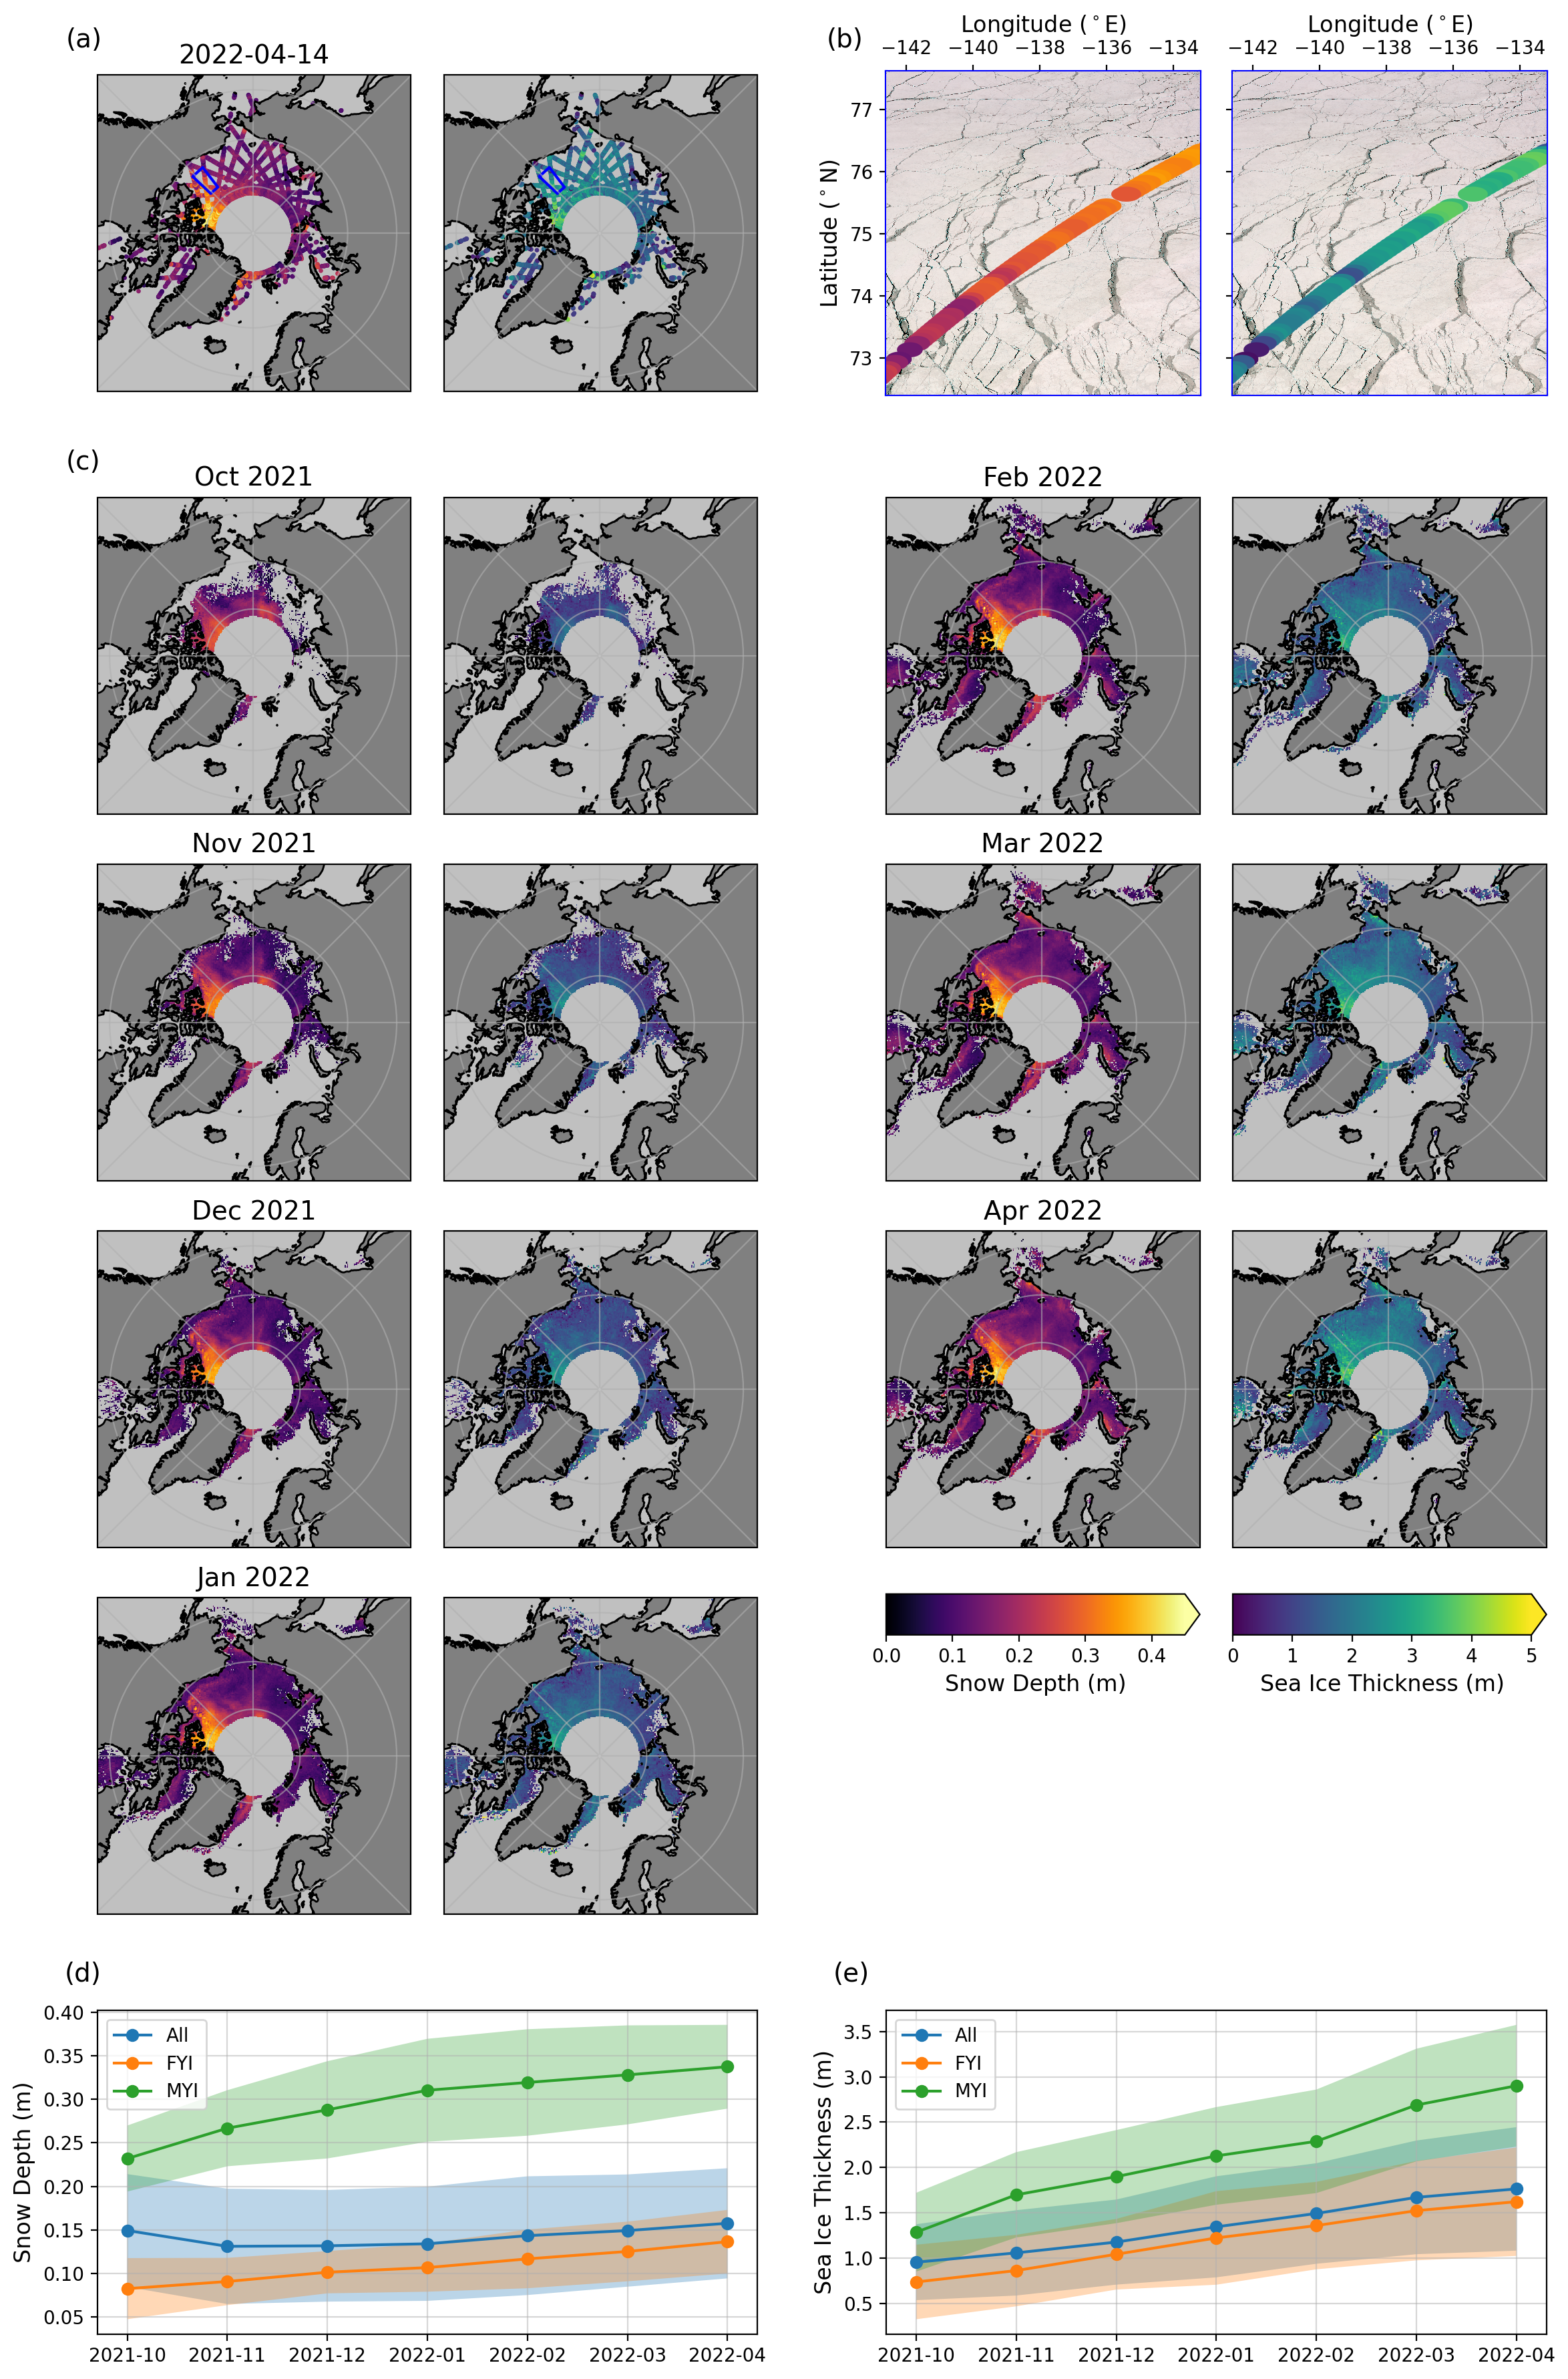

In [10]:
fig = plt.figure(figsize=(14, 22), dpi=200)
gs = GridSpec(8, 5, figure=fig, width_ratios=[1, 1, 0.2, 1, 1],
              height_ratios=[1, 0.04, 1, 1, 1, 1, 0.02, 1], hspace=0.175, wspace=0.125)

#first row, first two cols (0,1): daily scatter plots
daily_ax = []
for col in range(2):
    ax = fig.add_subplot(gs[0, col], projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 57, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, color='silver')
    ax.add_feature(cfeature.LAND, color='gray', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=False, dms=False, x_inline=True, y_inline=True, xlocs=[-135, -90, -45, 0, 45, 90, 135, 180], ylocs=[60, 70, 80], alpha=0.6)
    daily_ax.append(ax)
    
daily_ax[0].set_title(f'{date.strftime("%Y-%m-%d")}', fontsize=14)
daily_sd_scatter = daily_ax[0].scatter(date_s3_ds['lon_01'], date_s3_ds['lat_01'],
                                       c=date_s3_ds['snow_depth_01'], cmap='inferno',
                                       transform=ccrs.PlateCarree(), vmin=sd_vmin, vmax=sd_vmax, s=2)
daily_ax[0].add_geometries([bbox_polygon], crs=ccrs.PlateCarree(), facecolor='none',
                           edgecolor='blue', linewidth=1.5)
daily_ax[0].text(-0.1, 1.15, '(a)', fontsize=14, va='top', ha='left', transform=daily_ax[0].transAxes)

daily_sit_scatter = daily_ax[1].scatter(date_s3_ds['lon_01'], date_s3_ds['lat_01'],
                                        c=date_s3_ds['sea_ice_thickness_01'], cmap='viridis',
                                        transform=ccrs.PlateCarree(), vmin=sit_vmin, vmax=sit_vmax, s=2)
daily_ax[1].add_geometries([bbox_polygon], crs=ccrs.PlateCarree(), facecolor='none',
                           edgecolor='blue', linewidth=1.5)
daily_ax[1].text(1.22, 1.15, '(b)', fontsize=14, va='top', ha='left', transform=daily_ax[1].transAxes)

#first row, last two cols (3,4): snow depth and sea ice thickness over OLCI
ax1 = fig.add_subplot(gs[0, 3])
ax1.pcolormesh(
    img_rgb['lons'], img_rgb['lats'],
    img_rgb, zorder=5
)
ax1.set_xlim(bbox[0], bbox[1])
ax1.set_ylim(bbox[2], bbox[3])
for polygon, color in zip(mwr_polygons, s3_sd_colors):
    if polygon.exterior is not None:
        x, y = polygon.exterior.xy
        ax1.fill(x, y, color=color, alpha=1, zorder=10)
ax1.set_aspect('auto', adjustable='box')
ax1.set_xlabel(r'Longitude ($^\circ$E)', fontsize=12)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_ylabel(r'Latitude ($^\circ$N)', fontsize=12)
for edge in ['top', 'bottom', 'left', 'right']:
    ax1.spines[edge].set_color('blue')
    ax1.spines[edge].set_linewidth(1.5)

ax2 = fig.add_subplot(gs[0, 4])
ax2.pcolormesh(
    img_rgb['lons'], img_rgb['lats'],
    img_rgb, zorder=5
)
ax2.set_xlim(bbox[0], bbox[1])
ax2.set_ylim(bbox[2], bbox[3])
for polygon, color in zip(mwr_polygons, s3_sit_colors):
    if polygon.exterior is not None:
        x, y = polygon.exterior.xy
        ax2.fill(x, y, color=color, alpha=1, zorder=10)
ax2.set_aspect('auto', adjustable='box')
ax2.set_xlabel(r'Longitude ($^\circ$E)', fontsize=12)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
# ax2.set_ylabel('Latitude', fontsize=12)
for edge in ['top', 'bottom', 'left', 'right']:
    ax2.spines[edge].set_color('blue')
    ax2.spines[edge].set_linewidth(1.5)
# ax2.set_yticks([])
ax2.set_yticklabels([])

#second row (1): empty row for spacing

#create axes for the 4x5 grid of monthly maps
axs = []
for row in range(2, 6):  #start from the third row
    row_axes = []
    for col in range(5):
        #keep map axes for all positions, we'll reserve gs[5,3] and gs[5,4] later for shared colorbars
        if col == 2:
            row_axes.append(None)
        else:
            #for the last row's last two cells we'll still create axes (they will be overwritten by colorbar axes later)
            if row == 5 and col in (3, 4):
                ax = fig.add_subplot(gs[row, col])
            #create map axes for all other positions
            else:
                ax = fig.add_subplot(gs[row, col], projection=ccrs.NorthPolarStereo())
                ax.set_extent([-180, 180, 57, 90], ccrs.PlateCarree())
                ax.add_feature(cfeature.OCEAN, color='silver')
                ax.add_feature(cfeature.LAND, color='gray', edgecolor='black')
                ax.add_feature(cfeature.COASTLINE)
                ax.gridlines(draw_labels=False, dms=False, x_inline=True, y_inline=True,
                             xlocs=[-135, -90, -45, 0, 45, 90, 135, 180], ylocs=[60, 70, 80], alpha=0.6)
            row_axes.append(ax)
    axs.append(row_axes)

#plot the gridded data for each month
row_enum = 0
col_enum = 0
month_enum = 0
for i, (month_centre, gridded_vars) in enumerate(monthly_gridded_vars.items()):
    lons = gridded_vars['lon'].values
    lats = gridded_vars['lat'].values
    xcs = gridded_vars['x'].values
    ycs = gridded_vars['y'].values
    xcs, ycs = np.meshgrid(xcs, ycs)
    gridded_snow_depth = gridded_vars['snow_depth'].values
    gridded_sea_ice_thickness = gridded_vars['sea_ice_thickness'].values

    sd_ax = axs[row_enum][col_enum]
    sit_ax = axs[row_enum][col_enum + 1]

    sd_pcolor = sd_ax.pcolormesh(xcs, ycs, gridded_snow_depth, transform=ccrs.epsg(6931),
                                 cmap='inferno', vmin=sd_vmin, vmax=sd_vmax)

    sit_pcolor = sit_ax.pcolormesh(xcs, ycs, gridded_sea_ice_thickness, transform=ccrs.epsg(6931),
                                   cmap='viridis', vmin=sit_vmin, vmax=sit_vmax)

    sd_ax.set_title(f'{month_centre.strftime("%b %Y")}', fontsize=14)
    if month_enum == 0:
        sd_ax.text(-0.1, 1.15, '(c)', fontsize=14, va='top', ha='left', transform=sd_ax.transAxes)

    row_enum = row_enum + 1 if row_enum != 3 else 0
    month_enum += 1
    col_enum = 0 if month_enum < 4 else 3
    
axs[3][3].remove()
axs[3][4].remove()

#place shared colorbars in the bottom row, cols 3 and 4
cax_sd = fig.add_subplot(gs[5, 3])
cax_sit = fig.add_subplot(gs[5, 4]) 

#create appended axes for the horizontal colorbars and draw the colorbars there (we don't want them to span the entire height of the cell)
divider_sd = make_axes_locatable(cax_sd)
cax_sd_cb = divider_sd.append_axes("top", size="15%", pad=0.08)
cb_sd = fig.colorbar(sd_sm, cax=cax_sd_cb, orientation='horizontal', extend='max') 
cb_sd.ax.tick_params(labelsize=10)
cb_sd.set_label('Snow Depth (m)', fontsize=12)

divider_sit = make_axes_locatable(cax_sit)
cax_sit_cb = divider_sit.append_axes("top", size="15%", pad=0.08)
cb_sit = fig.colorbar(sit_sm, cax=cax_sit_cb, orientation='horizontal', extend='max')
cb_sit.ax.tick_params(labelsize=10)
cb_sit.set_label('Sea Ice Thickness (m)', fontsize=12)

#hide the empty base axes so they don't draw spines, ticks or labels
cax_sd.axis('off')
cax_sit.axis('off')

#store the actual colorbar axes in the axs grid
axs[3][4] = cax_sit_cb

#bottom row, line plot for snow depth and sea ice thickness timeseries
ax_snow_depth_timeseries = fig.add_subplot(gs[7, :2]) 
for ice_type in ['all', 'fyi', 'myi']:
    subset = monthly_stats[(monthly_stats['region'] == 100) & 
                           (monthly_stats['variable'] == 'snow_depth') & 
                           (monthly_stats['ice_type'] == ice_type) &
                           (monthly_stats['snow_source'] == 's3')]
    ax_snow_depth_timeseries.plot(subset['Year-Month'], subset['mean'], label=f'{ice_type.upper()if ice_type != "all" else "All"}', marker='o')
    ax_snow_depth_timeseries.fill_between(subset['Year-Month'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)
ax_snow_depth_timeseries.set_ylabel('Snow Depth (m)', fontsize=12)
ax_snow_depth_timeseries.legend(fontsize=10)
ax_snow_depth_timeseries.grid(alpha=0.5)
ax_snow_depth_timeseries.text(-0.05, 1.15, '(d)', fontsize=14, va='top', ha='left', transform=ax_snow_depth_timeseries.transAxes)

ax_sit_timeseries = fig.add_subplot(gs[7, 3:])
for ice_type in ['all', 'fyi', 'myi']:
    subset = monthly_stats[(monthly_stats['region'] == 100) & 
                           (monthly_stats['variable'] == 'sea_ice_thickness') & 
                           (monthly_stats['ice_type'] == ice_type) &
                           (monthly_stats['snow_source'] == 's3')]
    ax_sit_timeseries.plot(subset['Year-Month'], subset['mean'], label=f'{ice_type.upper() if ice_type != "all" else "All"}', marker='o')
    ax_sit_timeseries.fill_between(subset['Year-Month'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)
ax_sit_timeseries.set_ylabel('Sea Ice Thickness (m)', fontsize=12)
ax_sit_timeseries.legend(fontsize=10)
ax_sit_timeseries.grid(alpha=0.5)
ax_sit_timeseries.text(-0.08, 1.15, '(e)', fontsize=14, va='top', ha='left', transform=ax_sit_timeseries.transAxes)

plt.tight_layout()
plt.savefig(f's3_monthly_gridded_snow_depth_sea_ice_thickness_{season_start_year}_with_daily_scatter_and_olci.png',
            bbox_inches='tight', dpi=300)
plt.show()

In [11]:
for year_month in sorted(monthly_stats['year-month'].unique()):
    subset = monthly_stats[(monthly_stats['region'] == 100) & (monthly_stats['year-month'] == year_month) & (monthly_stats['snow_source'] == 's3')]
    print(f'Year-Month: {pd.to_datetime(year_month).strftime("%Y-%m")}')
    print(f'Snow depth (all types): Mean: {subset[subset["variable"] == "snow_depth"]["mean"].values[0]:.3f} m, Std: {subset[subset["variable"] == "snow_depth"]["std"].values[0]:.3f} m')
    print(f'Snow depth (FYI): Mean: {subset[(subset["variable"] == "snow_depth") & (subset["ice_type"] == "fyi")]["mean"].values[0]:.2f} m, Std: {subset[(subset["variable"] == "snow_depth") & (subset["ice_type"] == "fyi")]["std"].values[0]:.2f} m')
    print(f'Snow depth (MYI): Mean: {subset[(subset["variable"] == "snow_depth") & (subset["ice_type"] == "myi")]["mean"].values[0]:.2f} m, Std: {subset[(subset["variable"] == "snow_depth") & (subset["ice_type"] == "myi")]["std"].values[0]:.2f} m')
    print()
    print(f'Sea ice thickness (all types): Mean: {subset[subset["variable"] == "sea_ice_thickness"]["mean"].values[0]:.3f} m, Std: {subset[subset["variable"] == "sea_ice_thickness"]["std"].values[0]:.3f} m')
    print(f'Sea ice thickness (FYI): Mean: {subset[(subset["variable"] == "sea_ice_thickness") & (subset["ice_type"] == "fyi")]["mean"].values[0]:.2f} m, Std: {subset[(subset["variable"] == "sea_ice_thickness") & (subset["ice_type"] == "fyi")]["std"].values[0]:.2f} m')
    print(f'Sea ice thickness (MYI): Mean: {subset[(subset["variable"] == "sea_ice_thickness") & (subset["ice_type"] == "myi")]["mean"].values[0]:.2f} m, Std: {subset[(subset["variable"] == "sea_ice_thickness") & (subset["ice_type"] == "myi")]["std"].values[0]:.2f} m')
    print()

Year-Month: 2021-10
Snow depth (all types): Mean: 0.149 m, Std: 0.065 m
Snow depth (FYI): Mean: 0.08 m, Std: 0.04 m
Snow depth (MYI): Mean: 0.23 m, Std: 0.04 m

Sea ice thickness (all types): Mean: 0.956 m, Std: 0.418 m
Sea ice thickness (FYI): Mean: 0.74 m, Std: 0.41 m
Sea ice thickness (MYI): Mean: 1.29 m, Std: 0.43 m

Year-Month: 2021-11
Snow depth (all types): Mean: 0.131 m, Std: 0.066 m
Snow depth (FYI): Mean: 0.09 m, Std: 0.03 m
Snow depth (MYI): Mean: 0.27 m, Std: 0.04 m

Sea ice thickness (all types): Mean: 1.059 m, Std: 0.470 m
Sea ice thickness (FYI): Mean: 0.86 m, Std: 0.39 m
Sea ice thickness (MYI): Mean: 1.70 m, Std: 0.47 m

Year-Month: 2021-12
Snow depth (all types): Mean: 0.132 m, Std: 0.064 m
Snow depth (FYI): Mean: 0.10 m, Std: 0.02 m
Snow depth (MYI): Mean: 0.29 m, Std: 0.06 m

Sea ice thickness (all types): Mean: 1.178 m, Std: 0.469 m
Sea ice thickness (FYI): Mean: 1.04 m, Std: 0.39 m
Sea ice thickness (MYI): Mean: 1.90 m, Std: 0.51 m

Year-Month: 2022-01
Snow depth 

In [12]:
central_arctic_code = 1
caa_code = 12
laptev_sea_code = 5
barents_sea_code = 7

year_month = '2022-04'
for code, region in zip([central_arctic_code, caa_code, laptev_sea_code, barents_sea_code], ['Central Arctic', 'Canadian Arctic Archipelago', 'Laptev Sea', 'Barents Sea']):
    subset = monthly_stats[(monthly_stats['region'] == code) & (pd.to_datetime(monthly_stats['year-month']).dt.strftime("%Y-%m") == year_month) & (monthly_stats['snow_source'] == 's3')]
    print(f'Region: {region} ({code})')
    print(f'Snow depth (all types): Mean: {subset[subset["variable"] == "snow_depth"]["mean"].values[0]:.2f} m, Std: {subset[subset["variable"] == "snow_depth"]["std"].values[0]:.2f} m')

Region: Central Arctic (1)
Snow depth (all types): Mean: 0.19 m, Std: 0.08 m
Region: Canadian Arctic Archipelago (12)
Snow depth (all types): Mean: 0.20 m, Std: 0.08 m
Region: Laptev Sea (5)
Snow depth (all types): Mean: 0.11 m, Std: 0.03 m
Region: Barents Sea (7)
Snow depth (all types): Mean: 0.13 m, Std: 0.03 m
